In [1]:
# 导入数据
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False

%matplotlib inline

In [2]:
# 定义超参数
image_size = 28
num_classes = 10
num_epochs = 20
batch_size = 64
# learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 构建pipeline，对图像处理
pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

In [4]:
# 下载、加载数据集
train_dataset = dsets.MNIST(root='./data',
                        train=True,
                        download=True,
                        transform=pipeline) 
test_dataset = dsets.MNIST(root='./data',
                       train=False,
                       download=True,
                       transform=pipeline) 

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          sampler=sampler_test)

In [5]:
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = self.fc1(x)
        x = F.relu(x)
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x
    
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        
        return (feature_map1, feature_map2)

In [6]:
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    pred = pred.to(device)
    rights = pred.eq(labels.data.view_as(pred).to(device)).sum()
    rights = rights.to(device)
    return rights, len(labels)

In [7]:
net = ConvNet().to(device)

loss_arr = []
loss_epoch_arr = []
lr = [0.01, 0.05, 0.1, 0.5]

for item in lr:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=item, momentum=0.9)
    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data).to(device), Variable(target).to(device)
            net.train()

            output = net(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.item())
            
        loss_epoch_arr.append(loss.item())
        print('\r训练进度{}-{:.2f}%'.format(item ,(epoch+1) / (num_epochs+1) * 100), end='')

训练进度0.5-95.24%%

In [11]:
len(loss_arr) / 4

18760.0

In [12]:
len(loss_epoch_arr)

80

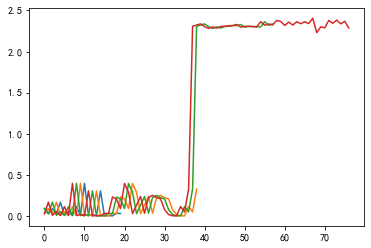

In [15]:
for i in range(4):
    plt.plot(loss_epoch_arr[i:(i+1)*20])

([<matplotlib.axis.XTick at 0x226fb32d610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

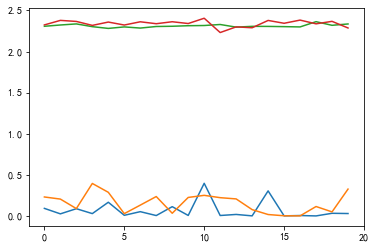

In [20]:
plt.plot(loss_epoch_arr[0:20])
plt.plot(loss_epoch_arr[20:40])
plt.plot(loss_epoch_arr[40:60])
plt.plot(loss_epoch_arr[60:80])
plt.xticks([0, 5, 10, 15, 20])

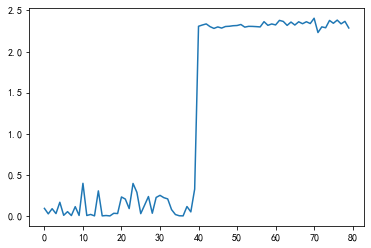

In [18]:
plt.plot(loss_epoch_arr)

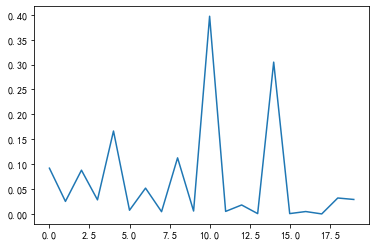

In [21]:
plt.plot(loss_epoch_arr[0:20])